In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Crach COLAB to get more RAM
'''
d=[]
while(1):
  d.append('1')
'''

"\nd=[]\nwhile(1):\n  d.append('1')\n"

In [0]:
#================== Copy Rights ==================
print('='*100)
print('Copy rights: Dr. Jan P. Nees, PhD.')
print('='*100)
#================== Import libraries ==================
import tensorflow as tf
#tf.enable_eager_execution()
#tf.executing_eagerly()

import os
import numpy as np
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
#from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, adam
#from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.models import load_model
import unicodedata
import re
import io
from keras import Sequential
from keras.layers import GRU, RepeatVector, TimeDistributed, Dense, LSTM, Input
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import TensorBoard
from time import time
import matplotlib.ticker as ticker
import numpy as np
from nltk.tokenize import sent_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#================== Methods ==================

#---------Tokenizer Method -----------------------------------
# ------ Main issues: Not sure if it does it correctly to DK and DE sentences. --------

def pad(x, length=106):
    #print('Padding version 1')
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')


def tokenize(x): # code from:
    from keras.preprocessing.text import Tokenizer
    x_tk = Tokenizer(num_words=500)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

#================== ======================================== ==================
#english_reader = load_data('europarl-v8.en')
#danish_reader = load_data('europarl-v8.da')

print('Dataset Loaded')

Copy rights: Dr. Jan P. Nees, PhD.


Using TensorFlow backend.


Dataset Loaded


In [0]:
versionTF = tf.__version__

if versionTF != '2.0.0':
  !pip install tensorflow==2.0.0
else:
  print(versionTF)

2.0.0


In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #w = re.sub(r"[å]+", "aa", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

#----------------------------------------------------------------------

def load_data_v2(path):
    
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    #w = preprocess_sentence(line) for line in lines
    #return w
    w = [preprocess_sentence(line)  for line in lines[:8000]] #<----------- How many lines of sentences
        #print(w)
            #data = preprocess_sentence(lines)
            #preprocess_sentence(data) 

    return w
#----------------------------------------------------------------------


print("""
Models has been loaded
Methods has been loaded
""")


Models has been loaded
Methods has been loaded



In [0]:
english_reader = load_data_v2('drive/My Drive/txt/europarl-v7.da-en.en')
danish_reader = load_data_v2('drive/My Drive/txt/europarl-v7.da-en.da')

print('Load finished')

Load finished


In [0]:
print(english_reader[1])
print(danish_reader[1])

<start> i declare resumed the session of the european parliament adjourned on friday december , and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . <end>
<start> jeg erklaerer europa parlamentets session , der blev afbrudt fredag den . december , for genoptaget . endnu en gang vil jeg oenske dem godt nytaar , og jeg haaber , de har haft en god ferie . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

print('tokenizer loaded')

tokenizer loaded


In [0]:
target_tensor, targ_lang = tokenize(english_reader)
input_tensor, inp_lang = tokenize(danish_reader)

print('target_tensor.shape: ', target_tensor.shape)
print('input_tensor.shape: ', input_tensor.shape)



target_tensor.shape:  (8000, 143)
input_tensor.shape:  (8000, 146)


In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

6400 6400 1600 1600


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
    
print('Model loaded')

Model loaded


In [0]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[1])

Input Language; index to word mapping
3 ----> <start>
8 ----> det
9 ----> er
59 ----> derfor
1993 ----> udelukket
1 ----> ,
5 ----> at
39 ----> europa
42 ----> parlamentet
169 ----> faar
170 ----> nogen
6922 ----> formel
972 ----> indflydelse
20 ----> paa
12844 ----> forhandlingsprocessen
51 ----> eller
40 ----> ved
4463 ----> ratificeringen
2 ----> .
4 ----> <end>

Target Language; index to word mapping
3 ----> <start>
18 ----> it
11 ----> is
79 ----> therefore
95 ----> out
6 ----> of
1 ----> the
108 ----> question
12 ----> that
1 ----> the
28 ----> european
41 ----> parliament
39 ----> should
17 ----> be
203 ----> given
93 ----> any
2042 ----> formal
1498 ----> influence
209 ----> over
1 ----> the
2230 ----> negotiation
184 ----> process
53 ----> or
209 ----> over
8554 ----> ratification
5 ----> .
4 ----> <end>


In [0]:
#=============================================================================
#================= TEXT ANALYSIS HERE ========================================
#=============================================================================

#------------- DATA processing-----------------
print('------- Data processing -------------')
english_words_counter = collections.Counter([word for sentence in english_reader for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in danish_reader for word in sentence.split()])
print('{} English words.'.format(len([word for sentence in english_reader for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('20 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(20)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in danish_reader for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('20 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(20)))[0]) + '"')

In [0]:
#=============================================================================
#================= INSERT OWN NN HERE ========================================
#=============================================================================

import time



In [0]:
#---------- Deep learning starts --------
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

print('Deep learning model pre-modelling finished')

print(dataset)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

print('--------- Deep Learning tensorflow begins ---------------')

Deep learning model pre-modelling finished
<BatchDataset shapes: ((64, 146), (64, 143)), types: (tf.int32, tf.int32)>
--------- Deep Learning tensorflow begins ---------------


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 146, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 146, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Decoder output shape: (batch_size, vocab size) (64, 9306)


In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

print('Method build finished')

Method build finished


In [0]:
import time

EPOCHS = 1

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7394
Epoch 1 Loss 1.2571
Time taken for 1 epoch 12626.807191371918 sec



In [0]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)


In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hvorfor er der ingen brandinstrukser . <end>
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


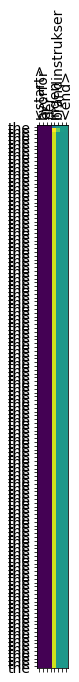

In [0]:
translate('hvorfor er der ingen brandinstrukser.')


Input: <start> hvor er eu <end>
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


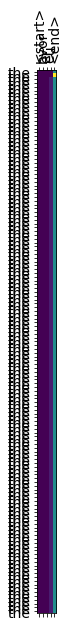

In [0]:
translate('hvor er EU')